In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import io
import math
from scipy.signal import convolve2d

一共输出五张图，从左往右，从上往下依次是原图片灰度图，8-bit量化器的重建图像，4-bit量化器的重建图像，2-bit量化器的重建图像，1-bit量化器的重建图像。重建图像的PSNR和SSIM值分别写在输出图像上方。

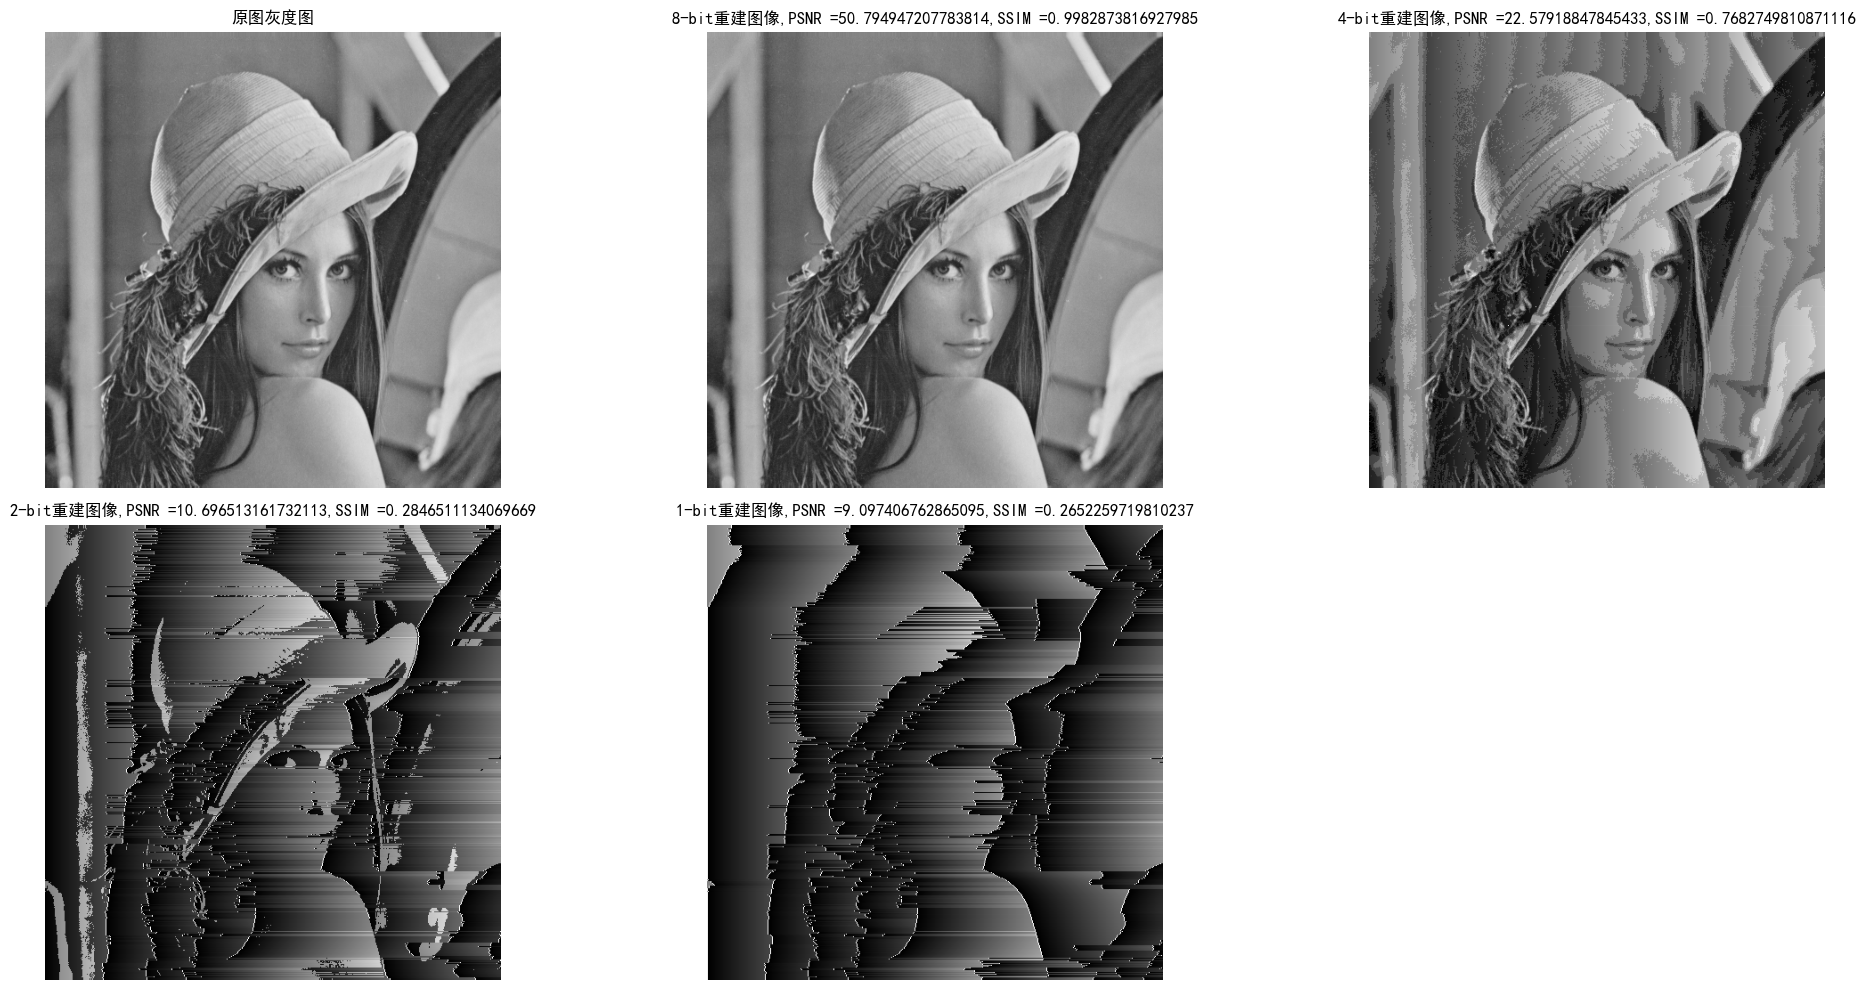

In [9]:
def DPCM(y,img_re,yprebuff,factor=8):
    radio=512/(1<<factor)  #量化因子  8是左向预测8bit量化
    for i in range(h):
        for j in range(w):
            # 左向预测8bit量化
            if j == 0:
                # 每行第一个像素做一定变换预测
                ypre = y[j + i * w]-128  # 计算预测误差
                yprebuff[j + i * w] = (ypre+255)/radio  # 量化预测误差
                img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+128  # 重建像素,j解码
                if img_re[j + i * w]>255:
                    img_re[j + i * w] = 255# 防止重建像素超过255
                yprebuff[j + i * w] = yprebuff[j + i * w]*radio/2

            else:
                ypre = y[j + i * w] - img_re[j + i * w - 1]
                yprebuff[j + i * w] = (ypre+255) /radio
                img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+img_re[j + i * w - 1]  # 反量化
                yprebuff[j + i * w] = yprebuff[j + i * w] * radio / 2  # 预测器
                if img_re[j + i * w]>255:
                    img_re[j + i * w] = 255
    img_re = img_re.astype(np.uint8) # 用来存储重建图像
    yprebuff = yprebuff.astype(np.uint8)  # 预测误差
    
    return y,img_re,yprebuff

 # target:目标图像  ref:参考图像 
def PSNR(target, ref):
    target = np.array(target, dtype=np.float32)
    ref = np.array(ref, dtype=np.float32)
 
    if target.shape != ref.shape:
        raise ValueError('输入图像的大小应该一致！')
 
    diff = ref - target
    diff = diff.flatten('C')
 
    rmse = math.sqrt( np.mean(diff ** 2.) )
    psnr = 20 * math.log10(np.max(target) / rmse)
 
    return psnr
 
 
def SSIM(target, ref, K1=0.01, K2=0.03, gaussian_kernel_sigma = 1.5, gaussian_kernel_width = 11, L=255):
    # 高斯核，方差为1.5，滑窗为11*11
    gaussian_kernel = np.zeros((gaussian_kernel_width,gaussian_kernel_width))
    for i in range(gaussian_kernel_width):
        for j in range(gaussian_kernel_width):
            gaussian_kernel[i,j] = (1 / (2 * math.pi * (gaussian_kernel_sigma ** 2))) * math.exp(-(((i-5) ** 2)+((j - 5) ** 2)) / (2 * (gaussian_kernel_sigma ** 2)))
 
    target = np.array(target, dtype=np.float32)
    ref = np.array(ref, dtype=np.float32)
    if target.shape != ref.shape:
        raise ValueError('输入图像的大小应该一致！')
 
    target_window = convolve2d(target, np.rot90(gaussian_kernel, 2), mode='valid')
    ref_window = convolve2d(ref, np.rot90(gaussian_kernel, 2), mode='valid')
 
    mu1_sq = target_window * target_window
    mu2_sq = ref_window * ref_window
    mu1_mu2 = target_window * ref_window
 
    sigma1_sq = convolve2d(target * target, np.rot90(gaussian_kernel, 2), mode='valid') - mu1_sq
    sigma2_sq = convolve2d(ref * ref, np.rot90(gaussian_kernel, 2), mode='valid') - mu2_sq
    sigma12 = convolve2d(target * ref, np.rot90(gaussian_kernel, 2), mode='valid') - mu1_mu2
 
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    ssim_array = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim = np.mean(np.mean(ssim_array))
 
    return ssim

# 读取图片，并转换为 y,v, u 分量。
img = cv2.imread('lena.jpg')
h, w = img.shape[:2]                      

yvu = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)# 将 BGR 转换为 YCrCb
y, v, u = cv2.split(yvu)


u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))
v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))

f = io.BytesIO()
f.write(y.tobytes())
f.write(u.tobytes())
f.write(v.tobytes())
f.seek(0)

img_np = np.frombuffer(f.read(), np.uint8)

img_yuv_len = img_np.size
img_y_len = h * w

y = img_np[:img_y_len]
u = img_np[img_y_len:(img_yuv_len - img_y_len) // 2 + img_y_len]
v = img_np[(img_yuv_len - img_y_len) // 2 + img_y_len:]

# DPCM量化编码，采用边编码，边解码的形式
img_re = np.zeros(img_y_len, np.uint16)  # 用来存储重建图像
yprebuff = np.zeros(img_y_len, np.uint16)  # 预测


# 重建图片,8-bit量化器
y8,img_re8,yprebuff8=DPCM(y,img_re,yprebuff,8)
y8 = y8.reshape((h,w))  # 转换向量形状回原来的y分量
yprebuff8 = yprebuff8.reshape((h,w))  # 预测的y分量
img_re8 = img_re8.reshape((h,w))  # 重建的y分量
PSNR8 = PSNR(y8,img_re8)
SSIM8 = SSIM(y8,img_re8)


# 重建图片,4-bit量化器
y4,img_re4,yprebuff4=DPCM(y,img_re,yprebuff,4)
y4 = y4.reshape((h,w))  # 转换向量形状回原来的y分量
yprebuff4 = yprebuff4.reshape((h,w))  # 预测的y分量
img_re4 = img_re4.reshape((h,w))  # 重建的y分量
PSNR4 = PSNR(y4,img_re4)
SSIM4 = SSIM(y4,img_re4)

# 重建图片,2-bit量化器
y2,img_re2,yprebuff2=DPCM(y,img_re,yprebuff,2)
y2 = y2.reshape((h,w))  # 转换向量形状回原来的y分量
yprebuff2 = yprebuff2.reshape((h,w))  # 预测的y分量
img_re2 = img_re2.reshape((h,w))  # 重建的y分量
PSNR2 = PSNR(y2,img_re2)
SSIM2 = SSIM(y2,img_re2)

# 重建图片,1-bit量化器
y1,img_re1,yprebuff1=DPCM(y,img_re,yprebuff,1)
y1 = y1.reshape((h,w))  # 转换向量形状回原来的y分量
yprebuff1 = yprebuff1.reshape((h,w))  # 预测的y分量
img_re1 = img_re1.reshape((h,w))  # 重建的y分量
PSNR1 = PSNR(y1,img_re1)
SSIM1 = SSIM(y1,img_re1)


bgr = cv2.cvtColor(yvu, cv2.COLOR_YCrCb2BGR)  # 将原来的y,u,v分量转换回图片


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(20, 10))
plt.subplot(231), plt.imshow(cv2.cvtColor(y8, cv2.COLOR_BGR2RGB),cmap='gray')
plt.title('原图灰度图'), plt.axis('off')
plt.subplot(232), plt.imshow(cv2.cvtColor(img_re8, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('8-bit重建图像,PSNR ='+str(PSNR8)+',SSIM ='+str(SSIM8)), plt.axis('off')
plt.subplot(233), plt.imshow(cv2.cvtColor(img_re4, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('4-bit重建图像,PSNR ='+str(PSNR4)+',SSIM ='+str(SSIM4)), plt.axis('off')
plt.subplot(234), plt.imshow(cv2.cvtColor(img_re2, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('2-bit重建图像,PSNR ='+str(PSNR2)+',SSIM ='+str(SSIM2)), plt.axis('off')
plt.subplot(235), plt.imshow(cv2.cvtColor(img_re1, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('1-bit重建图像,PSNR ='+str(PSNR1)+',SSIM ='+str(SSIM1)), plt.axis('off')

plt.tight_layout()
plt.show()